# [E1]rock_scissor_paper_classifier_sangmin   
이 classifier는 사람 손으로 가위바위보 모양을 만든 28x28x3 size 컬러이미지를 가위바위보 중에 무엇인지 분류한다. data_set은 가위 이미지 2400장, 바위 이미지 2400장, 보 이미지 2400장, 총 7200장 이다. train_set은 가위 이미지 200장, 바위 이미지 200장, 보 이미지 200장 총 600장 이다.   
이미지 데이터 수집 및 분리는 aiffel_slack에서 다운받은 뒤 각각 이름을 바꿔주고 resize했다. 그리고 전체 이미지 7800장 모두 섞여있다.

1. 라이브러리 import

In [3]:
#딥러닝 라이브러리
import tensorflow as tf
from tensorflow import keras
#행렬
import numpy as np
#파일 업로드
import os, glob
#그래프, 이미지 보기
import matplotlib.pyplot as plt
from PIL import Image

2. train_dataset과 test_dataset을 불러오기 및 라벨링 함수 설계 
총 *7200*개의 train_dataset과 *600*개의 test_dataset을 폴더에서 불러와서 numpy 행렬에 저장한다. 이미지 사이즈는 28x28x3 이다. 그리고 가위는 0, 바위는 1, 보는 2로 라벨링한다.

In [7]:
def load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=7200   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

def test_load_data(img_path):
    # 가위 : 0, 바위 : 1, 보 : 2
    number_of_data=600   # 가위바위보 이미지 개수 총합에 주의하세요.
    img_size=28
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1       
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("학습데이터(x_test)의 이미지 개수는",idx,"입니다.")
    return imgs, labels

3. 이미지 확인   
train_dataset 라벨링 함수를 실행하고 이미지를 잘 가져왔는지 plt라이브러리를 활용하여 확인한다.

학습데이터(x_train)의 이미지 개수는 7200 입니다.
label = 1


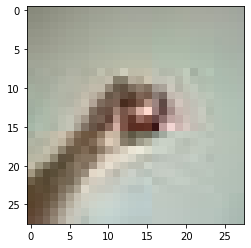

In [10]:
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train)=load_data(image_dir_path)

plt.imshow(x_train[2400])
print("label =", y_train[2400])

4. 정규화   
test_dataset 라벨링 함수를 실행하고 train_dataset과 test_dataset 데이터 값을 255로 전부 나누어 정규화한다

In [11]:
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화


test_image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper_test"
(x_test, y_test)=test_load_data(test_image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

학습데이터(x_test)의 이미지 개수는 600 입니다.


5. 모델 설계   
구글링 해보니 channel을 3개 써서 점차 증가하는 수를 넣어 주는 것이 보편적이였다. channel을 2개 쓰는 것보다 3개 쓰는 것이 결과가 좋았다. 그리고 dense 값은 20 ~ 512 사이의 값을 바꿔가며 줘봤지만 30일 때 결과가 좋았다. n_train_epoch은 20,30,50으로 해봤는데 50은 너무 오버피팅 되는 느낌이고 30이 적당했다. batch_size는 원래 기본 32로 돼있는데 이를 8로 낮추어 한번에 많이 넣었다. train_dataset이 좀 적다고 느껴져 8로 낮추었다. softmax dense 값은 가위, 바위, 보 3가지를 분류하는 것이기때문에 3을 넣어줘야 한다.

In [12]:
#바꿔 볼 수 있는 하이퍼파라미터들
n_channel_1 = 32
n_channel_2 = 64
n_channel_3 = 128
n_dense = 30
n_train_epoch = 30
n_train_batch_size = 8

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(n_channel_1, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(n_channel_2, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Conv2D(n_channel_3, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(n_dense, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 1, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

6. 모델 학습   
epochs 30, batch_size 8 로 지정해주고 학습 시켰다.

In [14]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])
model.fit(x_train_norm, y_train, epochs = n_train_epoch, batch_size = n_train_batch_size)

Epoch 1/30
900/900 [==============================] - 3s 3ms/step - loss: 0.9806 - accuracy: 0.4687
Epoch 2/30
900/900 [==============================] - 3s 3ms/step - loss: 0.4656 - accuracy: 0.8149
Epoch 3/30
900/900 [==============================] - 3s 3ms/step - loss: 0.2278 - accuracy: 0.9176
Epoch 4/30
900/900 [==============================] - 3s 3ms/step - loss: 0.1333 - accuracy: 0.9550
Epoch 5/30
900/900 [==============================] - 3s 3ms/step - loss: 0.1079 - accuracy: 0.9631
Epoch 6/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0798 - accuracy: 0.9715
Epoch 7/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0513 - accuracy: 0.9822
Epoch 8/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0595 - accuracy: 0.9808
Epoch 9/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0536 - accuracy: 0.9834
Epoch 10/30
900/900 [==============================] - 3s 3ms/step - loss: 0.0262 - accuracy: 0.9906

7. 모델 테스트   
모델 테스트를 하고 결과 값을 출력했다.

In [15]:
test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))
print("x_train shape: {}".format(x_train.shape))

19/19 - 0s - loss: 0.5789 - accuracy: 0.9100
test_loss: 0.5788967609405518 
test_accuracy: 0.9100000262260437
x_train shape: (7200, 28, 28, 3)


8. 결론 : 정확도 91%, 손실함수 0.5789

# 후기   
처음에 코드를 실행했을 때, 정확도는 50%는 정도였는데 loss값이 보통 300을 넘고 최소 88이였다.그래서 이미지도 더 다운받고 라벨링하고, n_channel_1, n_channel_2, n_channel_3, n_dense, n_train_epoch, n_train_batch_size 값만 주구장창 바꾸다가 soft max값이 10으로 돼어있다는 것을 5시간 만에 알고 3으로 바꿨다. 그래도 인식률만 10%정도 오르고 그대로였다. 그래서 포기하고 숙제 제출하려고 글쓰는 와중에, test_loss, test_accuracy = model.evaluate(x_test_norm,y_test, verbose=2) 이부분에 정규화 값을 안넣고 정규화 안된 값ㅠ 넣엏다는 것을 알아차렸다. 결국 다 고치고 나니 결과값이 매우 좋아서 만족했다ㅠㅠ